#### 1. Imports

In [3]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import os
import glob
import IPython
from scipy.io import wavfile 
import matplotlib.pyplot as plt
from configparser import ConfigParser
%matplotlib inline

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, CuDNNGRU
from keras.optimizers import Adam

from gen_noise_data import generate_noise_files
from utils import create_training_sample, graph_spectrogram

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### 2. Model

In [4]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, 15, strides=4)(X_input)             # CONV1D
    X = BatchNormalization(axis=-1)(X)                  # Batch normalization
    X = Activation('relu')(X)                           # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    print(X.get_shape())

    # Step 2: First GRU Layer (≈4 lines)
    X = CuDNNGRU(units = 128, return_sequences = True)(X)    # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = CuDNNGRU(units = 128, return_sequences = True)(X)    # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model

#### 3. Generate noise data files

In [5]:
generate_noise_files()

#### 4. Initialise path variables

In [6]:
# instantiate
config = ConfigParser()

# parse existing file
config.read('config.ini')

root = config.get('section_path', 'data_path')
data = config.get('section_path', 'training_data')

# path to noise data - 3 seconds each generated by 'gen_noise_data.py'
noise = data + config.get('section_path', 'out_noise_path')

# path to negative data
negativ = r"raw_data\negative\\"

inPathLeft = root + config.get('section_path', 'left')
outPathLeft = data + config.get('section_path', 'left')

#### 4. Training
We will generate training data for keywords "left" and "right" on the fly.

Time steps in input after spectrogram (101, 5511)


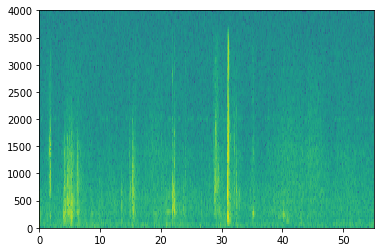

In [7]:
# initialize Tx, n_freq, Ty
for file in os.listdir(noise):
    _, data = wavfile.read(noise + file)
    x = graph_spectrogram(data)
    break
print("Time steps in input after spectrogram", x.shape)

Tx = x.shape[1] # The number of time steps input to the model from the spectrogram
n_freq = x.shape[0] # Number of frequencies input to the model at each time step of the spectrogram

Ty = 1375 # The number of time steps in the output of our model

In [8]:
model = model(input_shape = (Tx, n_freq))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
(?, 1375, 196)
Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [10]:
# count files "left" folder
LeftFiles = len(glob.glob(inPathLeft + "*.wav"))
print(LeftFiles)

2167


In [11]:
background = []
negative = []
left = []
    
X = []
Y = []

In [ ]:
# read all noise files in an array
for file in os.listdir(noise):
    if file.endswith("wav"):
        bak = AudioSegment.from_wav(noise + file)
        background.append(bak)
        
# read all negative files in an array
for file in os.listdir(negativ):
    if file.endswith("wav"):
        neg = AudioSegment.from_wav(negativ + file)
        negative.append(neg)
        
fileIdx = 0
npIndx = 0
gcount = 0
for j in range(10):
    for i in range(len(background)):
        count = LeftFiles
        for file in os.listdir(inPathLeft):
            if file.endswith("wav"):
                if(gcount % 5 == 0 and gcount > 0):
                    # print('count' ,str(gcount), str(len(left)) )
                    LeftX, LeftY = create_training_sample(background[i], left, negative, fileIdx)
                    left = []
                    fileIdx += 1
                    X.append(LeftX)
                    Y.append(LeftY)
                    if(gcount % 4000 == 0 and gcount > 0):
                        X = np.asarray(X)
                        Y = np.asarray(Y)
                        #np.save(outPathLeft + "np-array\X-" + str(npIndx) + "-.npy", X)
                        #np.save(outPathLeft + "np-array\Y-" + str(npIndx) + "-.npy", Y)
                    
                        J = X.swapaxes(1,2)
                        K = Y.swapaxes(1,2)
                    
                        model.fit(J, K, batch_size = 32, epochs=50)
                    
                        X = []
                        Y = []
                        J = []
                        K = []
                        npIndx += 1
                pos = AudioSegment.from_wav(inPathLeft + file)
                left.append(pos)
                count -= 1
                gcount += 1 
X = []
Y = []

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Epoch 1/50
800/800 [==============================] - 12s 15ms/step - loss: 1.1730 - acc: 0.4988
Epoch 2/50
800/800 [==============================] - 8s 10ms/step - loss: 1.0071 - acc: 0.5007
Epoch 3/50
800/800 [==============================] - 8s 10ms/step - loss: 0.9590 - acc: 0.5193
Epoch 4/50
800/800 [==============================] - 8s 10ms/step - loss: 0.9432 - acc: 0.5538
Epoch 5/50
800/800 [==============================] - 8s 10ms/step - loss: 0.9302 - acc: 0.5896
Epoch 6/50
192/800 [======>.......................] - ETA: 6s - loss: 0.9310 - acc: 0.6090

4531

In [22]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    _, data = wavfile.read(filename)
    x = graph_spectrogram(data)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    #print(predictions)
    print(np.amax(predictions))
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [23]:
chime_file = r"raw_data\chime\chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 45 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 30:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export(r"raw_data\chime\chime_output.wav", format='wav')

In [24]:
IPython.display.Audio(r"D:\\test\\nleft.wav")

0.4261707


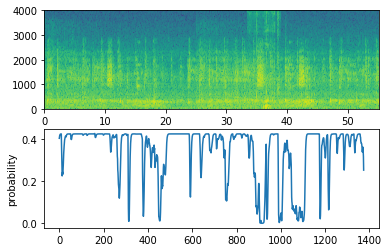

In [26]:
filename = r"D:\\test\\nleft.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.42617)
IPython.display.Audio(r"raw_data\chime\chime_output.wav")